# Various simulations related to the signature and the randomized signature with sigmoid additions

### Mechanism for Brownian Motion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
from timeit import default_timer as timer

In [3]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigm_v = np.vectorize(sigmoid)

In [594]:
id_v = np.vectorize(lambda a : a)
sq_v =  np.vectorize(lambda a : a*a)
cu_v =  np.vectorize(lambda a : a*a*a)
quo_v =  np.vectorize(lambda a : 1/(1+abs(a)))
sqrt_v = np.vectorize(math.sqrt)
log_v = np.vectorize(math.log)
sin_v = np.vectorize(math.sin)
arctan_v = np.vectorize(np.arctan)

In [595]:
arctan_v([1,2,3,4])

array([0.78539816, 1.10714872, 1.24904577, 1.32581766])

In [253]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w

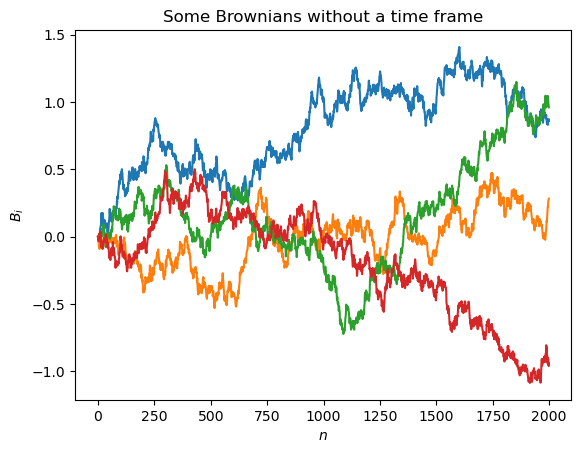

In [254]:
b = Brownian()
for i in range(4):
    plt.plot(1*b.gen_normal(2000))

plt.title("Some Brownians without a time frame")
plt.xlabel("$n$")
plt.ylabel("$B_i$")
plt.show()

#### Function for scaling constant

In [6]:
def scaling(d, M):
    r = 1
    for i in range(d):
        r += M ** (i+1)
    return r

In [7]:
print(scaling(10, 4))

1398101


### Mechanism for random matrices and vectors

In [8]:
A = np.random.normal(0, 1, size=(3, 2, 4))
v = np.random.normal(0, 1, size=(3))

In [9]:
A, v

(array([[[-0.50885566,  1.24995233, -1.44199719, -0.16725842],
         [-0.38669922,  1.32948829, -1.09868058,  1.00926035]],
 
        [[-0.6827976 ,  0.67863564, -0.87239657, -0.05266064],
         [-0.6403174 , -0.57264758, -1.14471893, -0.36000027]],
 
        [[-0.06503595,  0.09414358,  0.73631939, -0.85554127],
         [-0.66622102, -0.46230211, -1.48449652, -0.26108979]]]),
 array([-1.49856707,  0.98127618,  1.85546924]))

### Time&step structure

In [10]:
N = 1001
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

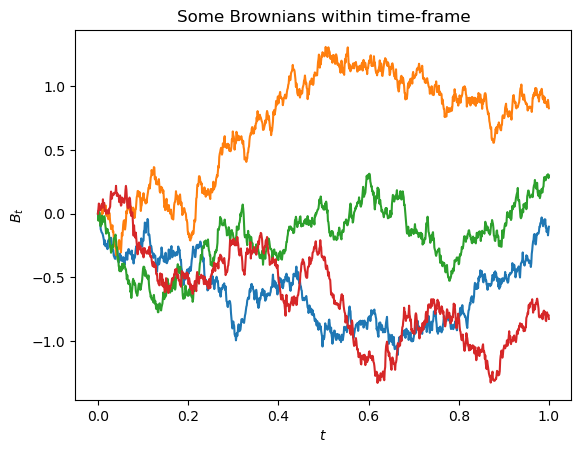

In [11]:
for i in range(4):
    plt.plot(x_axis, b.gen_normal(N))
plt.title("Some Brownians within time-frame")
plt.xlabel("$t$")
plt.ylabel("$B_t$")
plt.show()

## 1-Dimensional Stochastic Double Well

### Time&step structure

In [20]:
N = 1001
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

### Constructing the process

In [27]:
b = Brownian()

theta, mu, sigma, y0 = 1, 2, 1, 1
Y = np.zeros(N)
Y[0] = y0
brow = b.gen_normal(N+1)
db =  np.diff(brow)

In [28]:
for i in range(N-1):
    Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]

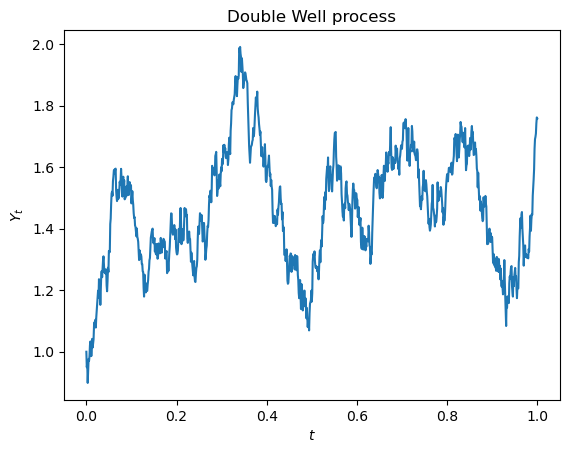

In [648]:
plt.plot(x_axis, Y)
plt.title("Double Well process")
plt.xlabel("$t$")
plt.ylabel("$Y_t$")
plt.show()

### Constructing the randomized signature

In [30]:
k = 50
A = np.random.normal(0, 1, size=(k, k))
b = np.random.normal(0, 1, size=k)
dY = np.diff(Y)
Z = np.zeros((N, k))
Z[0][0] = 1

##### With sigmoid

In [31]:
for i in range(N-1):
    Z[i+1] =   Z[i] + sigm_v(A@Z[i] + b)*dY[i] 

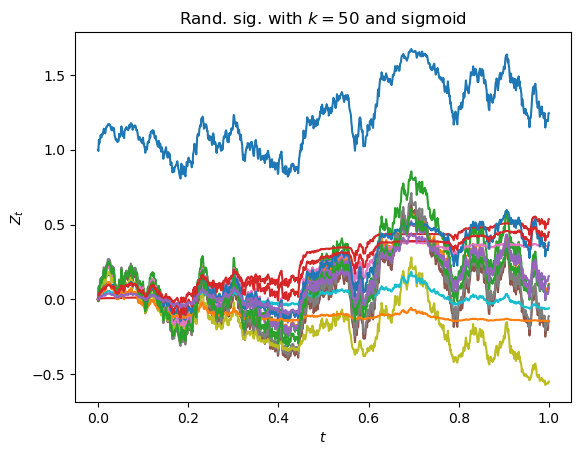

In [32]:
for i in range(15):
    plt.plot(x_axis, Z[:,i])

plt.title("Rand. sig. with $k = 50$ and sigmoid")
plt.xlabel("$t$")
plt.ylabel("$Z_t$")
plt.show()

### Training the linear, time-homogeneous readout for just one sample - without regularization

In [255]:
target_func = cu_v

In [256]:
target = target_func(Y)

In [257]:
model1 = LinearRegression().fit(Z, target)

In [258]:
r_sq_1 = model1.score(Z,target)
print(f"coefficient of determination: {r_sq_1}")

coefficient of determination: 0.9999999999832139


In [259]:
print(f"intercept: {model1.intercept_}")

intercept: 1.0234997594020703


In [260]:
print(f"coefficients: {model1.coef_}")

coefficients: [-2.34996474e-02  1.79976130e-02 -2.23380518e-02  7.33177117e-03
 -2.03014539e-03 -3.04254452e-02 -2.39948320e-02  3.61761406e-02
  6.48143833e-03  5.09914748e-02 -5.04021246e-02 -7.61372883e-02
  5.04879569e-03  1.44881555e-03 -2.05826033e-02  1.77229388e-02
  6.41298788e-01  6.32769850e-02 -4.03790212e-03  3.13927871e-02
 -2.68574098e-02 -9.81138781e-03  4.58169554e-03  7.10948865e-02
  1.86446405e-02 -1.07760880e-02  6.83457649e-04  6.02314961e-03
 -1.35053977e-03 -1.67592834e-02  7.63069575e-03 -7.63820645e-03
  1.24677431e-02 -5.74113393e-06  1.80851402e-01 -3.92999737e-03
  1.53296436e-02  4.04738166e-03  6.57578785e-02  5.39144947e-02
  1.10022314e-02 -6.04246220e-03 -1.40774380e-02 -8.82866054e-02
 -6.33113778e-02 -2.66434292e-03  5.07054999e-02  5.00100063e-02
  8.93698272e-03 -9.10817450e-03  3.86807564e-02 -9.00779438e-02
 -8.94625214e-03 -2.55385013e-02  7.67113795e-02  4.32549587e-02
 -4.24260175e-02  8.35811090e-03  2.92531803e-01 -1.27294526e-03
  1.9628906

In [261]:
Y_pred_1 = model1.predict(Z)

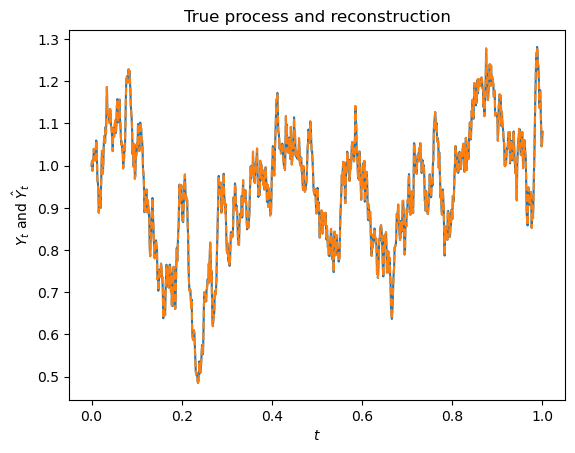

In [262]:
plt.plot(x_axis, target)
plt.plot(x_axis, Y_pred_1, '--')
plt.title("True process and reconstruction")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

### Simulating n_sim times and testing out of sample with Gaussians - $g_1$ to $g_6$

In [864]:
target_func = arctan_v

In [875]:
n_sim = 200
k = 200
A = np.random.normal(0, 1, size=(k, k))
b = np.random.normal(0, 1, size=k)
Y_big = np.zeros(N*n_sim)
target_big = np.zeros(N*n_sim)
Z_big = np.zeros((N*n_sim, k))
Y_big[0:N,] = np.ones(N)
Z_big[0:N,].shape

(1001, 200)

In [876]:
for iter in range(n_sim):

    br = Brownian()
    Y = np.zeros(N)
    Y[0] = y0
    brow = br.gen_normal(N+1)
    db =  np.diff(brow)
    for i in range(N-1):
        Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]
    dY = np.diff(Y)
    Z = np.zeros((N, k))
    Z[0][0] = 1
    for i in range(N-1):
        Z[i+1] = Z[i] + sigm_v(A@Z[i] + b)*dY[i]
    Y_big[iter*N:(iter+1)*N] = Y
    Z_big[iter*N:(iter+1)*N,:] = Z
    
    target = target_func(Y)
    target_big[iter*N:(iter+1)*N] = target

In [877]:
model3 = Ridge(alpha=0.01)
model3.fit(Z_big, target_big)

Ridge(alpha=0.01)

In [878]:
r_sq_3 = model3.score(Z_big, target_big)
print(f"coefficient of determination: {r_sq_3}")

coefficient of determination: 0.9891708235825002


In [879]:
print(f"intercept: {model3.intercept_}")

intercept: 0.6627071029359346


In [880]:
print(f"coefficients: {model3.coef_}")

coefficients: [ 0.06017969  0.07176536  0.09191249  0.00542572 -0.09838812 -0.07561497
  0.08719083  0.07627748 -0.02446226 -0.02378843  0.01026963  0.11177463
  0.06985885 -0.05033114 -0.1153792  -0.01677967 -0.10262802  0.11003784
  0.09543237  0.06716506  0.06615586  0.27998514  0.12908018  0.05399792
  0.06973017  0.00440154 -0.03963918 -0.05803483 -0.0469882   0.06097723
 -0.05620056  0.05525045  0.02265751  0.06711189  0.17133034  0.04289639
  0.14232513  0.11758075  0.06858904 -0.05444425  0.22824785 -0.01605331
 -0.09143097  0.14230343  0.11886566  0.13968279 -0.21019704 -0.02671529
 -0.0861586  -0.22133518 -0.01946292  0.10436604 -0.1864303   0.0890039
 -0.00133541 -0.035465   -0.00802977  0.11826726 -0.16394634 -0.10124883
  0.0917046   0.00075528 -0.22429258 -0.14904068 -0.00887488  0.05745842
  0.01485592  0.04583521  0.28647553 -0.21720113 -0.05620494 -0.06598097
 -0.10290855  0.07821856  0.01667774 -0.1848      0.06240085  0.19513358
  0.03944826  0.10460449  0.10503781  

In [881]:
br = Brownian()
Y = np.zeros(N)
Y[0] = y0
brow = br.gen_normal(N+1)
db =  np.diff(brow)
for i in range(N-1):
    Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]
dY = np.diff(Y)
Z = np.zeros((N, k))
Z[0][0] = 1
for i in range(N-1):
    Z[i+1] = Z[i] + sigm_v(A@Z[i] + b)*dY[i]
target = target_func(Y)

In [882]:
Y_pred_3 = model3.predict(Z)

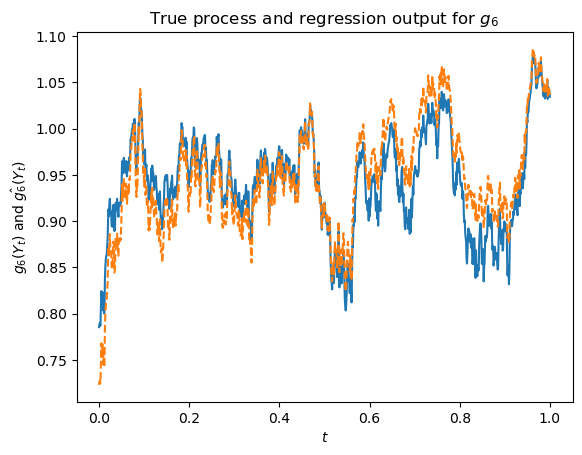

In [885]:
#Y_big[0:N]
plt.plot(x_axis, target)
plt.plot(x_axis, Y_pred_3, '--')
plt.title("True process and regression output for $g_6$")
plt.xlabel("$t$")
plt.ylabel("$g_6(Y_t)$ and $\hat{g_6}(Y_t)$")
plt.show()

In [884]:
np.linalg.norm(target-Y_pred_3)/np.linalg.norm(target)

0.029263574978719623

## 4-Dimensional Ornstein–Uhlenbeck process

### Time&step structure

In [1877]:
N = 365
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

### Constructing the process

In [1878]:
y0_4, mu_4 = np.array([1,1,1,1]), np.array([1,1,1,1])
sigma_4 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
theta_4 = np.array([[1,1/2,1/3,1/4], [2,1,2/3,2/4], [3,3/2,1,3/4], [4,2,4/3,1]])
Y_4 = np.zeros((N,4))
Y_4[0] = y0_4
brow_4 = np.zeros((N+1,4))
#sigma_4 = theta_4

In [1879]:
br_4 = Brownian()

for i in range(4):
    brow_4[:,i] = br_4.gen_normal(N+1)
db_4 = np.diff(brow_4, axis = 0)

In [1880]:
for i in range(N-1):
    Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]

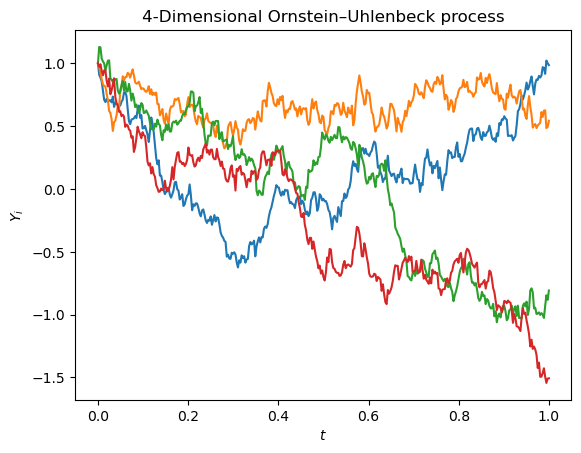

In [1881]:
for i in range(4):
    plt.plot(x_axis, Y_4[:,i])

plt.title("4-Dimensional Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Y_i$")
plt.show()

### Constructing the randomized signature

In [1882]:
k_4 = 30
A_4 = np.random.normal(0, 1, size=(4, k_4, k_4))
b_4 = np.random.normal(0, 1, size=(4,k_4))
dY_4 = np.diff(Y_4, axis = 0)
Z_4 = np.zeros((N, k_4))
Z_4[0][0] = 1
#Z_4[0,:] = np.random.normal(0, 1, size=k_4)

##### with sigmoid

In [1883]:
for i in range(N-1):
    auxiliary = 0
    for j in range(4):
        auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
    Z_4[i+1] = Z_4[i] + auxiliary

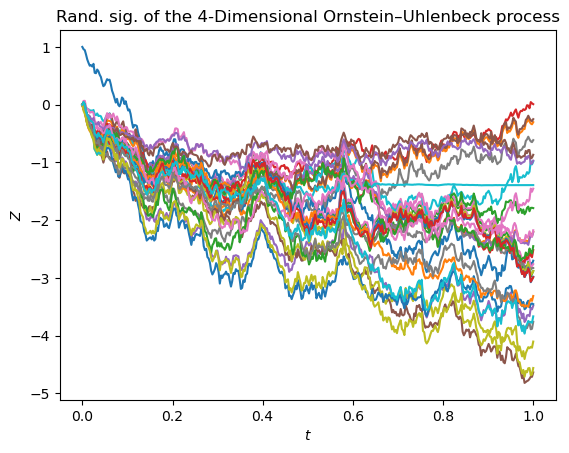

In [1884]:
for i in range(k_4):
    plt.plot(x_axis, Z_4[:,i])

plt.title("Rand. sig. of the 4-Dimensional Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

### Defining some additional functions to recreate

In [1803]:
def first_component(Y):
    return Y[:,0]

In [1804]:
def second_component(Y):
    return Y[:,1]

In [1805]:
def third_component(Y):
    return Y[:,2]

In [1806]:
def fourth_component(Y):
    return Y[:,3]

### Recreating in sample

In [1807]:
Z_4

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75032817, -0.25151296, -0.30649215, ..., -0.1547786 ,
        -0.31778085, -0.28955589],
       [ 0.54873048, -0.29945492, -0.48251605, ..., -0.32650807,
        -0.34476317, -0.39311148],
       ...,
       [-5.36143371, -3.33450274, -4.11052662, ..., -6.7817406 ,
        -2.99307909, -6.39933495],
       [-5.02733681, -3.20833448, -3.9347749 , ..., -6.47972395,
        -2.80457186, -6.09747183],
       [-4.26091212, -2.99301305, -3.59060587, ..., -5.92004262,
        -2.39511122, -5.53809952]])

In [1808]:
target_func = second_component

In [1809]:
target_4 = target_func(Y_4)

In [1810]:
model5 = LinearRegression().fit(Z_4, target_4)

In [1811]:
r_sq_5 = model5.score(Z_4,target_4)
print(f"coefficient of determination: {r_sq_5}")

coefficient of determination: 0.9999999994788178


In [1812]:
print(f"intercept: {model5.intercept_}")

intercept: 1.0012214747302253


In [1813]:
print(f"coefficients: {model5.coef_}")

coefficients: [-1.22147444e-03  5.84641974e-03  4.01290759e-03 -3.68124390e-02
  1.52034627e-03  5.16082463e-05  2.50911238e-03 -1.66236394e-03
  4.91321310e-03 -2.45422959e-01 -1.01156045e-02 -1.06756893e-01
 -1.38612260e-01  3.02568342e-04 -5.30335936e-04 -1.52886840e-02
  8.08562324e-02 -6.71020512e-04  1.87717590e-01  6.14191092e-01
 -2.18354719e-03  2.08415058e-02  6.74045113e-03  2.06815255e-01
  2.10676738e-02  2.80623443e-01 -1.38648450e-03 -9.14007818e-02
 -7.06697983e-04  3.57604027e-03]


In [1814]:
Y_pred_5 = model5.predict(Z_4)

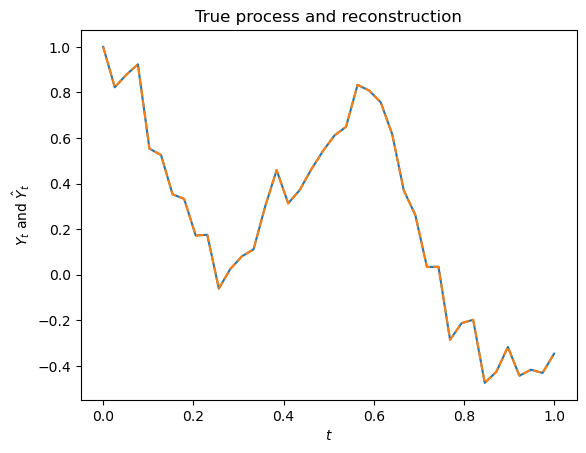

In [1815]:
plt.plot(x_axis, target_4)
plt.plot(x_axis, Y_pred_5, '--')
plt.title("True process and reconstruction")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

### Simulating n_sim times and testing out of sample with Gaussians - $g_7$ to $g$

In [1836]:
target_func = first_component

In [1837]:
N

40

In [1853]:
n_sim_4 = 200
k_4 = 5
A_4 = np.random.normal(0, 1, size=(4, k_4, k_4))
b_4 = np.random.normal(0, 1, size=(4,k_4))
Y_big_4 = np.zeros((N*n_sim_4, 4))
target_big_4 = np.zeros(N*n_sim_4)
Z_big_4 = np.zeros((N*n_sim_4, k_4))
#Y_big_4[0:N,] = np.ones((N,4))
Y_big_4[0:N,].shape

(40, 4)

In [1854]:
for iter in range(n_sim_4):
    
    Y_4 = np.zeros((N,4))
    Y_4[0] = y0_4
    brow_4 = np.zeros((N+1,4))
    
    
    br_4 = Brownian()

    for i in range(4):
        brow_4[:,i] = br_4.gen_normal(N+1)
    db_4 = np.diff(brow_4, axis = 0)
    
    for i in range(N-1):
        Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]
        
    dY_4 = np.diff(Y_4, axis = 0)
    Z_4 = np.zeros((N, k_4))
    Z_4[0][0] = 1
    
    for i in range(N-1):
        auxiliary = 0
        for j in range(4):
            auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
        Z_4[i+1] = Z_4[i] + auxiliary
        
        
        
        
    Y_big_4[iter*N:(iter+1)*N,:] = Y_4
    Z_big_4[iter*N:(iter+1)*N,:] = Z_4
    
    target_4 = target_func(Y_4)
    target_big_4[iter*N:(iter+1)*N] = target_4

In [1855]:
model4 = Ridge(alpha=0.001)
model4.fit(Z_big_4, target_big_4)

Ridge(alpha=0.001)

In [1856]:
r_sq_4 = model4.score(Z_big_4, target_big_4)
print(f"coefficient of determination: {r_sq_4}")

coefficient of determination: 0.9730836771799529


In [1857]:
print(f"intercept: {model4.intercept_}")

intercept: 0.9487926372637493


In [1858]:
print(f"coefficients: {model4.coef_}")

coefficients: [ 0.03241522  0.08656194 -0.05577504  0.00829488  0.12331398 -0.0372026
  0.16835055  0.19424519 -0.01780752 -0.08307642 -0.04337719 -0.08382994
  0.03561603 -0.03301615  0.14895425  0.01022111  0.10798854 -0.02709177
 -0.05492922 -0.08329327 -0.02390074 -0.00042021  0.15374869  0.00150615
 -0.37003276 -0.07363872  0.04464394 -0.06584773  0.02649929 -0.26200798
 -0.09865391 -0.05726943  0.07037724  0.17500942 -0.12167216 -0.00865822
  0.02294981 -0.03407115  0.18698724  0.02651606  0.02684035  0.00947861
 -0.07988633  0.01388252  0.26786521 -0.00702573  0.03362592 -0.05066539
  0.00398283 -0.2590918  -0.04055532 -0.09246327  0.03461807 -0.05158949
  0.07205989  0.07716105]


In [1859]:
Y_4 = np.zeros((N,4))
Y_4[0] = y0_4
brow_4 = np.zeros((N+1,4))


br_4 = Brownian()

for i in range(4):
    brow_4[:,i] = br_4.gen_normal(N+1)
db_4 = np.diff(brow_4, axis = 0)

for i in range(N-1):
        Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]
        
dY_4 = np.diff(Y_4, axis = 0)
Z_4 = np.zeros((N, k_4))
Z_4[0][0] = 1

for i in range(N-1):
    auxiliary = 0
    for j in range(4):
        auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
    Z_4[i+1] = Z_4[i] + auxiliary
target_4 = target_func(Y_4)

In [1860]:
Z_big_4[0:N,:].shape

(40, 56)

In [1861]:
Y_big_4[0:N,:].shape

(40, 4)

In [1862]:
Y_pred_4 = model4.predict(Z_4)

In [1863]:
Y_pred_4.shape

(40,)

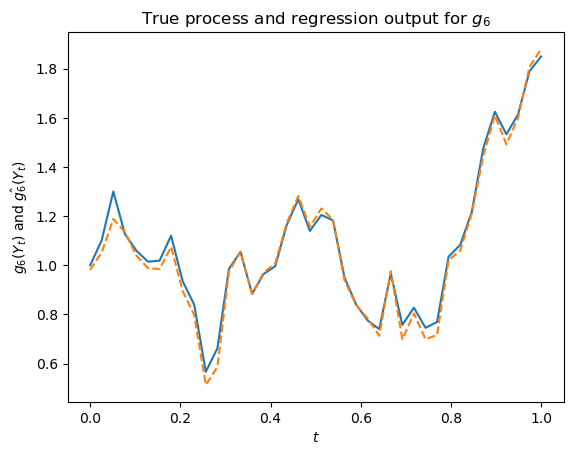

In [1864]:
#Y_big[0:N]
plt.plot(x_axis, target_4)
plt.plot(x_axis, Y_pred_4, '--')
plt.title("True process and regression output for $g_6$")
plt.xlabel("$t$")
plt.ylabel("$g_6(Y_t)$ and $\hat{g_6}(Y_t)$")
plt.show()

In [1865]:
np.linalg.norm(target_4-Y_pred_4)/np.linalg.norm(target_4)

0.031039953490715127

In [1866]:
Y_pred_4 = model4.predict(Z_big_4[0:N,:])

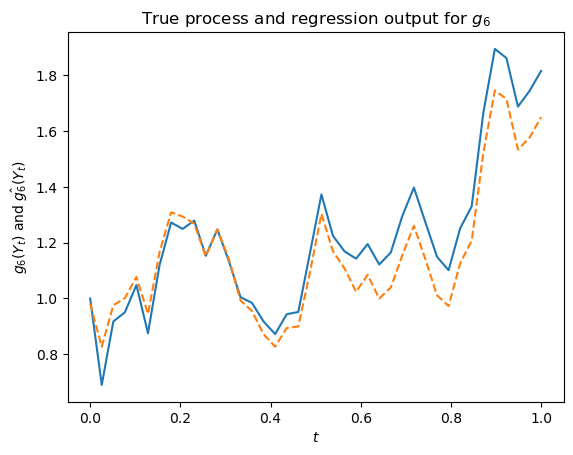

In [1867]:
#Y_big[0:N]
plt.plot(x_axis, Y_big_4[0:N,0])
plt.plot(x_axis, Y_pred_4, '--')
plt.title("True process and regression output for $g_6$")
plt.xlabel("$t$")
plt.ylabel("$g_6(Y_t)$ and $\hat{g_6}(Y_t)$")
plt.show()

In [1868]:
np.linalg.norm(Y_big_4[0:N,0]-Y_pred_4)/np.linalg.norm(Y_big_4[0:N,0])

0.07875540441877152

## 10-Dimensional Made-Up process

In [916]:
y0_10, mu_10 = np.ones(10), np.ones(10)
sigma_10 = np.eye(10)
theta_10 = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        theta_10[i][j] = (i+1)/(j+1)

In [917]:
Y_10 = np.zeros((N,10))
Y_10[0] = y0_10
brow_10 = np.zeros((N+1,10))

In [918]:
b_10 = Brownian()

for i in range(10):
    brow_10[:,i] = b_10.gen_normal(N+1)
db_10 = np.diff(brow_10, axis = 0)

In [919]:
for i in range(N-1):
    Y_10[i+1] = Y_10[i] + (mu_10 - theta_10 @ Y_10[i]) * step + sigma_10 @ db_10[i]

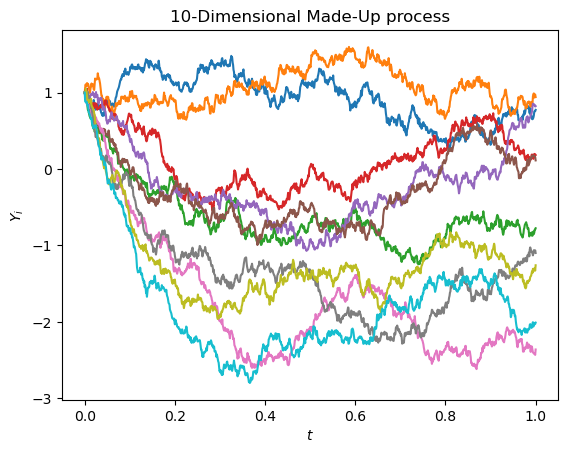

In [920]:
for i in range(10):
    plt.plot(x_axis, Y_10[:,i])

plt.title("10-Dimensional Made-Up process")
plt.xlabel("$t$")
plt.ylabel("$Y_i$")
plt.show()

### Constructing the randomized signature - 10-Dimensional Made-Up process

In [921]:
k_10 = 10
A_10 = np.random.normal(0, 1, size=(10, k_10, k_10))
b_10 = np.random.normal(0, 1, size=(10, k_10))
dY_10 = np.diff(Y_10, axis = 0)
Z_10 = np.zeros((N, k_10))
Z_10[0][0] = 1

In [922]:
dY_10.shape

(1000, 10)

In [923]:
lambda_d10 = 1 / scaling(10, 4)

In [926]:
for i in range(N-1):
    for j in range(10):
        Z_10[i+1] = Z_10[i] + sigm_v(A_10[j]@Z_10[i] + b_10[j])*dY_10[i][j]

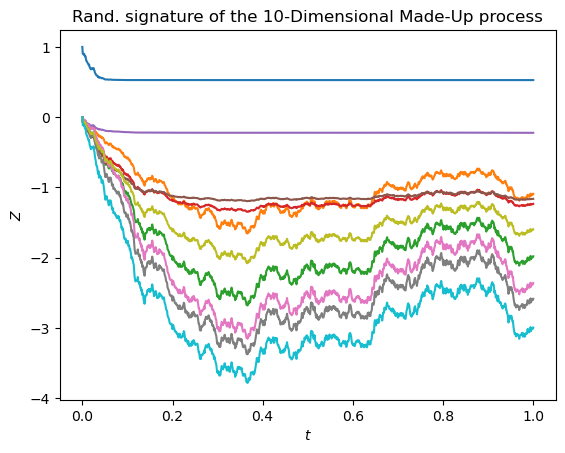

In [927]:
for i in range(10):
    plt.plot(x_axis, Z_10[:,i])

plt.title("Rand. signature of the 10-Dimensional Made-Up process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

### $Nsim$-Dimensional generalized Ornstein–Uhlenbeck process

In [928]:
Nsim = 50 #free to choose dimensionality of the generalized process

In [929]:
y0_Nsim, mu_Nsim = np.ones(Nsim), np.ones(Nsim)
sigma_Nsim = np.eye(Nsim)
theta_Nsim = np.zeros((Nsim, Nsim))

for i in range(Nsim):
    for j in range(Nsim):
        theta_Nsim[i][j] = (i+1)/(j+1)

In [930]:
Y_Nsim = np.zeros((N,Nsim))
Y_Nsim[0] = y0_Nsim
brow_Nsim = np.zeros((N+1,Nsim))

In [931]:
b_Nsim = Brownian()

for i in range(Nsim):
    brow_Nsim[:,i] = b_Nsim.gen_normal(N+1)
db_Nsim = np.diff(brow_Nsim, axis = 0)

In [932]:
for i in range(N-1):
    Y_Nsim[i+1] = Y_Nsim[i] + (mu_Nsim - theta_Nsim @ Y_Nsim[i]) * step + sigma_Nsim @ db_Nsim[i]

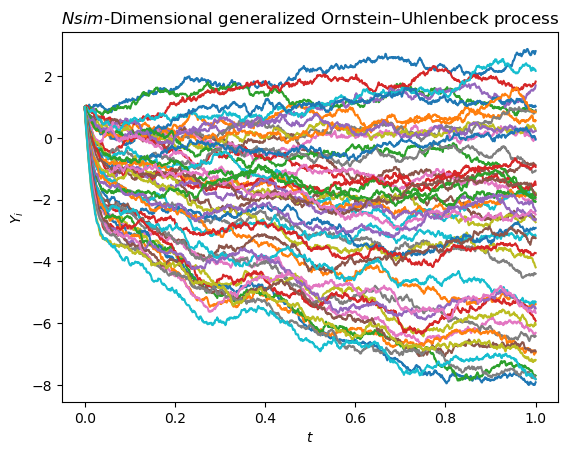

In [933]:
for i in range(Nsim):
    plt.plot(x_axis, Y_Nsim[:,i])

plt.title("$Nsim$-Dimensional generalized Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Y_i$")
plt.show()

### Constructing the randomized signature - $Nsim$-Dimensional generalized Ornstein–Uhlenbeck process

In [934]:
N = 101
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

In [935]:
k_Nsim = 1000 #free to choose dimensionality of the rand. signature

In [936]:
A_Nsim = np.random.normal(0, 1, size=(Nsim, k_Nsim, k_Nsim))
b_Nsim = np.random.normal(0, 1, size=(Nsim, k_Nsim))
dY_Nsim = np.diff(Y_Nsim, axis = 0)
Z_Nsim = np.zeros((N, k_Nsim))
Z_Nsim[0][0] = 1

In [937]:
dY_Nsim.shape

(1000, 50)

In [938]:
lambda_dNsim = 1 / scaling(10, 4)

In [939]:
start = timer()
for i in range(N-1):
    for j in range(Nsim):
        Z_Nsim[i+1] = Z_Nsim[i] + sigm_v(A_Nsim[j]@Z_Nsim[i] + b_Nsim[j])*dY_Nsim[i][j]
end = timer()
print(end - start)

5.967199200000323


In [940]:
print(N)

101


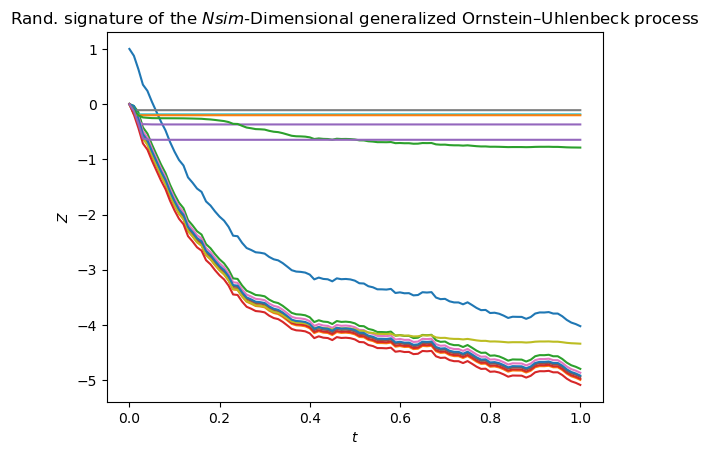

In [941]:
for i in range(15):
    plt.plot(x_axis, Z_Nsim[:,i])

plt.title("Rand. signature of the $Nsim$-Dimensional generalized Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()